In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.models import load_model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 1)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 64)     640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 128)    73856       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 3, 3, 128)    0           conv2d_1[0][0]                   
_______________________________________________________________________________________

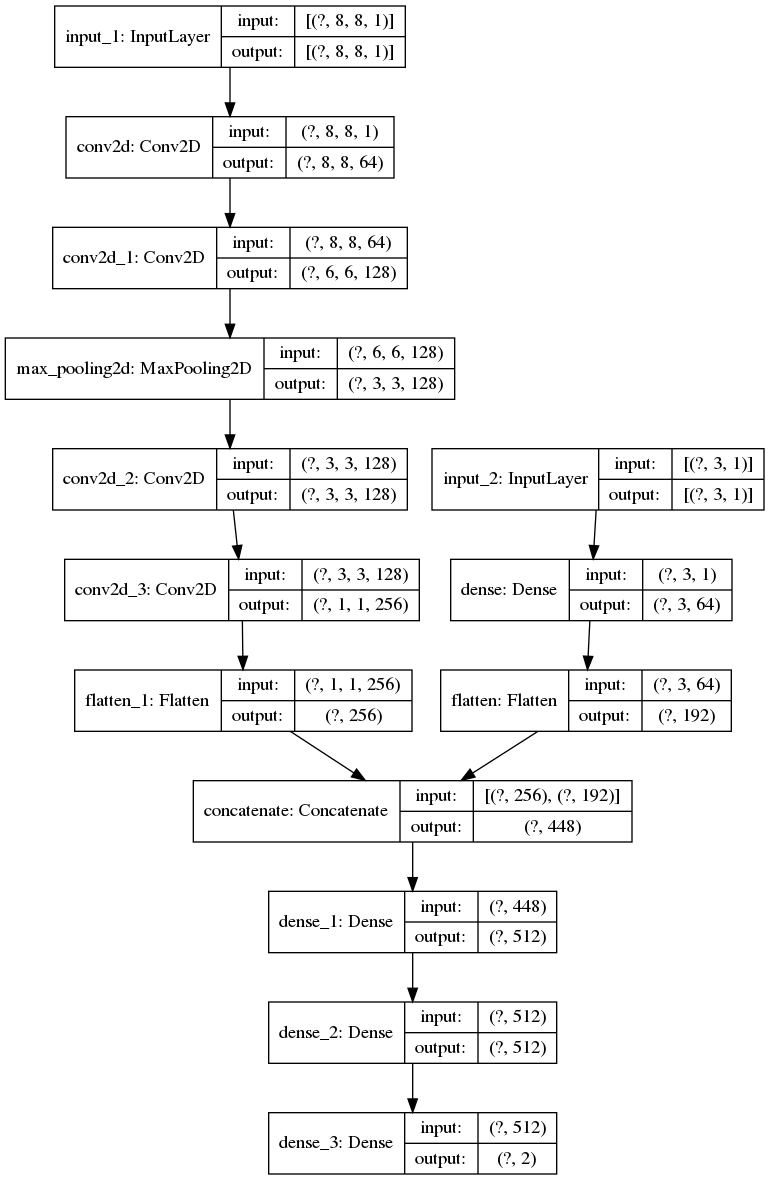

In [2]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
inputs2 = Input(shape=input_shape2)
# y = Dropout(0.2)(inputs)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           padding='same',
           activation='relu')(inputs)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)

y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
           padding='same',
           activation='relu')(y)
y = Conv2D(filters=filters*4,
           kernel_size=kernel_size,
           activation='relu')(y)
# y = Dropout(dropout)(y)

y2 = Dense(filters, activation='relu')(inputs2)
y2 = Flatten()(y2)

# image to vector before connecting to dense layer
y = Flatten()(y)
y = Concatenate()([y,y2])
y = Dense(filters*8, activation='relu')(y)
y = Dense(filters*8, activation='relu')(y)
# dropout regularization
# y = Dropout(dropout)(y)
outputs = Dense(2, activation='tanh')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=[inputs,inputs2], outputs=outputs)
# network model in text
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [6]:
model = load_model('my_model3.h5')

In [7]:
def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [8]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None, mintemp = 26, maxtemp = 32):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))

In [9]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(16,-1,100,8,8,1).transpose(1,0,2,3,4,5)
    
    
    file_path = "amax.json"
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    arr_list= json.loads(obj_text)
    arr_ans = reg_interpolate(np.array(arr_list),4,4*(ln**2),16,4*(ln**2))
    arr_ans = reg_interpolate(arr_ans.transpose(1,0),4,16*(ln**2),dis,16*(ln**2)).reshape(dis,16,ln**2).transpose(1,0,2)
#     print(np.mean(arr_ans))
#     print(np.amax(arr_ans))
#     print(np.amin(arr_ans))
    temp_arr = np.array([27.44472821, 26.27245937, 21.30507148, 18.32839891])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2,100))
    y_train[0] = ((np.ones((100,16,dis,ln**2))*arr_ans).transpose(1,2,3,0)-29)/6
    y_train[1] = (np.ones((dis,ln**2,100,16))*temp_inter).transpose(3,0,1,2)/25 -1
    y_train[2] = (np.ones((16,ln**2,100,dis))*np.linspace(0.25,1.75,dis)).transpose(0,3,1,2)-1
    pos_x = np.array([np.arange(1/6,2,1/3),]*6)-1
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,100,ln**2))*pos_x.reshape(-1)).transpose(0,1,3,2)
    y_train[4] = (np.ones((16,dis,100,ln**2))*pos_y.reshape(-1)).transpose(0,1,3,2)
    y_train = y_train.reshape(5,16,-1,100).transpose(2,1,3,0)
    
    x_train2 = []
    y_train2 = []
    for k in range(16):
        for i in range(x_train.shape[0]):
            for j in range(i+1,x_train.shape[0]):
                
                _a = random.randint(0,99)
                _b = random.randint(0,99)
                _x = np.zeros((2,8,8,1))
                _x[0] = x_train[i,k,_a]
                _x[1] = x_train[j,k,_b]
                _x = np.amax(_x, axis = 0)
#                 if i == 0 and j == 5+k:
#                     show_temp(x_train[i,k,_a])
#                     show_temp(x_train[j,k,_b])
#                     show_temp(_x)
                x_train2.append(_x)
                x_train2.append(_x)
                
                #add noise
                mu, sigma = 0, 0.01 # mean and standard deviation
                _na = np.random.normal(mu, sigma, 5)
                _nb = np.random.normal(mu, sigma, 5)
                y_train2.append(y_train[i,k,_a]+_na)
                y_train2.append(y_train[j,k,_b]+_nb)
            
    x_train2 = np.array(x_train2)
    y_train2 = np.array(y_train2)
    
    
    indices = np.arange(x_train2.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train2.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train2[indices[:-ind]],y_train2[indices[:-ind],2:], y_train2[indices[:-ind],:2], x_train2[indices[-ind:-ind_half]], y_train2[indices[-ind:-ind_half],2:],y_train2[indices[-ind:-ind_half],:2], x_train2[indices[-ind_half:]], y_train2[indices[-ind_half:],2:], y_train2[indices[-ind_half:],:2]

In [10]:
x_train, x_train2, y_train, x_test, x_test2, y_test, x_val,x_val2, y_val = load_temperature()

print(x_train.shape)
print(x_train2.shape)
print(y_train.shape)

print(x_test.shape)
print(x_test2.shape)
print(y_test.shape)

print(x_val.shape)
print(x_val2.shape)
print(y_val.shape)

(4239360, 8, 8, 1)
(4239360, 3)
(4239360, 2)
(529920, 8, 8, 1)
(529920, 3)
(529920, 2)
(529920, 8, 8, 1)
(529920, 3)
(529920, 2)


In [11]:
np.median(abs((model.predict([x_test, x_test2])*np.array([6,25])+np.array([27,25]))-(y_test*np.array([6,25])+np.array([27,25]))),axis = 0)

array([0.06184774, 0.18047316])

In [13]:
batch_size = 256
score = model.evaluate([x_test,x_test2], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
score = model.evaluate([x_val,x_val2], y_val, batch_size=batch_size)
print("\nValidation accuracy: %.1f%%" % (100.0 * score[1]))

2070/2070 [==============================] - 3s 1ms/step - loss: 4.0999e-04 - accuracy: 0.9815

Test accuracy: 98.2%
2070/2070 [==============================] - 3s 1ms/step - loss: 4.0374e-04 - accuracy: 0.9818

Validation accuracy: 98.2%


In [14]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([28.19163723, 26.99398514, 22.64881059, 19.28525343])
amb_dis = np.array([[ 2.2 ,  2.47,  2.44,  2.01],
       [ 0.62,  0.74,  1.  ,  1.84],
       [-1.85, -1.38, -0.35,  0.97],
       [-2.91, -3.16, -2.83, -1.81]])

for i in range(4):
    cubic = interp1d(dis_head, amb_dis[i], kind='cubic')
    poly_dis[i] = np.polyfit(dis_head,cubic(dis_head),3)
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    cubic = interp1d(amb_temp, amb_pts, kind='cubic')
    poly = np.polyfit(amb_temp,cubic(amb_temp),3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 7.19).round(2)

In [22]:
res = np.array(model.predict([x_test, x_test2])*np.array([6,25])+np.array([27,25]))

In [23]:
res.shape

(529920, 2)

In [26]:
for i in range(100):
    print(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]*2+2.5))

36.8
35.74
32.93
34.76
37.11
37.92
38.24
33.09
37.78
32.18
34.69
33.56
32.19
33.79
36.14
38.21
39.91
35.23
35.88
34.76
35.79
37.57
35.25
36.94
35.18
34.5
32.08
33.91
35.38
37.24
38.04
38.2
36.16
33.63
35.0
34.23
37.49
32.28
32.95
36.08
34.54
34.74
39.04
37.07
35.17
35.55
38.52
35.85
34.02
34.04
35.04
33.88
36.51
32.88
32.81
35.26
37.24
38.52
36.19
32.73
38.61
35.55
34.04
34.07
31.27
34.72
37.27
35.12
33.95
38.69
35.3
37.58
32.28
37.26
34.19
31.56
33.65
34.92
33.34
37.28
36.09
35.65
38.36
34.7
41.35
32.61
36.28
38.44
38.27
33.06
31.73
33.26
36.39
38.91
35.48
38.67
37.79
35.43
33.71
34.79


In [28]:
for i in range(100):
    print(get_bodytemp(y_test[i,0]*6+27,y_test[i,1]*25+25,x_test2[i,0]*2+2.5))

36.82
35.78
32.94
34.29
37.06
37.79
38.25
32.91
37.74
32.65
34.64
32.68
32.33
33.83
36.13
37.37
40.58
34.99
35.57
34.84
35.74
37.63
35.33
36.74
35.12
34.53
32.18
33.9
35.33
37.54
37.9
38.31
36.22
33.61
35.08
34.36
37.56
32.25
33.08
36.08
34.64
34.93
39.84
37.09
35.3
35.91
38.6
35.71
33.99
33.92
34.98
34.2
36.61
32.81
32.29
34.94
37.25
38.5
36.3
32.78
38.12
35.75
34.07
33.79
31.23
34.69
37.3
35.37
33.03
38.6
35.24
37.76
32.61
37.3
33.89
30.66
33.59
35.11
33.48
37.45
36.06
35.51
37.91
34.75
42.12
32.31
36.59
38.86
38.27
32.56
31.66
33.4
36.5
38.75
35.22
38.06
37.81
35.56
33.61
34.84


In [29]:
for i in range(100):
    print(abs(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]*2+2.5) - get_bodytemp(y_test[i,0]*6+27,y_test[i,1]*25+25,x_test2[i,0]*2+2.5)))

0.020000000000003126
0.03999999999999915
0.00999999999999801
0.46999999999999886
0.04999999999999716
0.13000000000000256
0.00999999999999801
0.18000000000000682
0.03999999999999915
0.46999999999999886
0.04999999999999716
0.8800000000000026
0.14000000000000057
0.03999999999999915
0.00999999999999801
0.8400000000000034
0.6700000000000017
0.23999999999999488
0.3100000000000023
0.0800000000000054
0.04999999999999716
0.060000000000002274
0.0799999999999983
0.19999999999999574
0.060000000000002274
0.030000000000001137
0.10000000000000142
0.00999999999999801
0.05000000000000426
0.29999999999999716
0.14000000000000057
0.10999999999999943
0.060000000000002274
0.020000000000003126
0.0799999999999983
0.13000000000000256
0.07000000000000028
0.030000000000001137
0.12999999999999545
0.0
0.10000000000000142
0.18999999999999773
0.8000000000000043
0.020000000000003126
0.12999999999999545
0.35999999999999943
0.0799999999999983
0.14000000000000057
0.030000000000001137
0.11999999999999744
0.06000000000000

In [30]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(-1,8,8,1) 
    
    
    file_path = "amax.json"
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    arr_list= json.loads(obj_text)
    arr_ans = reg_interpolate(np.array(arr_list),4,4*(ln**2),16,4*(ln**2))
    arr_ans = reg_interpolate(arr_ans.transpose(1,0),4,16*(ln**2),dis,16*(ln**2)).reshape(dis,16,ln**2).transpose(1,0,2)
    print(np.mean(arr_ans))
    print(np.amax(arr_ans))
    print(np.amin(arr_ans))
    temp_arr = np.array([27.44472821, 26.27245937, 21.30507148, 18.32839891])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2,100))
    y_train[0] = ((np.ones((100,16,dis,ln**2))*arr_ans).transpose(1,2,3,0)-29)/6
    y_train[1] = (np.ones((dis,ln**2,100,16))*temp_inter).transpose(3,0,1,2)/25 -1
    y_train[2] = (np.ones((16,ln**2,100,dis))*np.linspace(0.25,1.75,dis)).transpose(0,3,1,2)-1
    pos_x = np.array([np.arange(1/6,2,1/3),]*6)-1
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,100,ln**2))*pos_x.reshape(-1)).transpose(0,1,3,2)
    y_train[4] = (np.ones((16,dis,100,ln**2))*pos_y.reshape(-1)).transpose(0,1,3,2)
    y_train = y_train.reshape(5,-1).T
    
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train[indices[:-ind]], y_train[indices[:-ind]], x_train[indices[-ind:-ind_half]], y_train[indices[-ind:-ind_half]], x_train[indices[-ind_half:]], y_train[indices[-ind_half:]]

In [31]:
x_train, y_train, x_test, y_test, x_val, y_val = load_temperature()

29.698043749419394
32.22236585365853
25.355951393356776


In [32]:
for i in range(100):
    print(get_bodytemp(y_test[i,0]*6+27,y_test[i,1]*25+25,y_test[i,2]*2+2.5))

36.29
35.17
38.24
36.92
38.68
35.64
36.5
38.67
35.82
34.56
31.83
36.22
33.09
37.61
38.99
37.59
34.31
34.98
34.7
34.8
32.44
39.64
34.99
36.24
36.22
35.17
36.82
38.7
36.16
33.03
36.72
35.08
34.14
36.47
36.99
37.54
37.05
37.22
37.87
34.74
31.43
34.77
34.04
35.01
36.93
34.63
33.55
34.94
35.17
35.26
35.48
38.09
35.12
34.79
36.55
37.92
33.73
36.04
35.53
35.29
32.3
36.15
33.73
34.4
39.84
34.66
31.84
34.67
37.11
35.97
35.65
35.49
38.92
35.14
36.83
33.23
35.37
37.36
33.37
33.2
34.81
34.42
40.28
31.73
33.04
37.39
36.6
36.45
35.05
33.92
39.39
35.1
34.03
34.47
35.45
32.24
35.27
34.67
33.86
36.02


In [49]:
ln = 6
dis = 16
file_path = "amax.json"
obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
arr_list= json.loads(obj_text)
arr_ans = reg_interpolate(np.array(arr_list),4,4*(ln**2),16,16*(ln**2)).reshape(16,16,ln,ln)
# arr_ans = reg_interpolate(np.array(arr_list),4,4*(ln**2),16,4*(ln**2))
# arr_ans = reg_interpolate(arr_ans.transpose(1,0,2,3),4,16*(ln**2),dis,16*(ln**2)).reshape(dis,16,ln**2).transpose(1,0,2)

In [46]:

arr_ans[0,0].round(2)

array([31.46, 31.77, 31.22, 31.78, 31.78, 32.01, 31.43, 31.31, 31.89,
       31.82, 31.76, 31.67, 31.92, 31.79, 31.8 , 31.65, 31.48, 31.75,
       31.62, 31.73, 31.63, 31.88, 31.79, 31.99, 31.61, 31.75, 31.69,
       31.84, 31.58, 32.22, 31.75, 32.05, 32.09, 31.75, 32.07, 31.74])

In [47]:
arr_ans[15,0].round(2)

array([26.7 , 26.86, 26.59, 27.03, 26.58, 26.25, 26.18, 26.16, 26.38,
       26.62, 26.56, 26.4 , 26.36, 26.29, 25.77, 26.42, 26.07, 25.81,
       26.91, 27.14, 27.33, 27.27, 27.08, 26.84, 25.74, 26.42, 26.4 ,
       26.82, 26.67, 26.27, 25.36, 25.61, 26.04, 26.09, 25.55, 25.72])

In [48]:
np.array(arr_list)[0,0].round(2)

array([[31.46, 31.77, 31.22, 31.78, 31.78, 32.01],
       [31.43, 31.31, 31.89, 31.82, 31.76, 31.67],
       [31.92, 31.79, 31.8 , 31.65, 31.48, 31.75],
       [31.62, 31.73, 31.63, 31.88, 31.79, 31.99],
       [31.61, 31.75, 31.69, 31.84, 31.58, 32.22],
       [31.75, 32.05, 32.09, 31.75, 32.07, 31.74]])